In [1]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import VanillaSampler, PartitionedSampler, ApproximatedSampler, LayerWiseApproxSampler,ApproximatedMulDimSampler, goodnight
from rbmpy.trainer import VanillaTrainier, ORBMTrainer
from rbmpy.performance import Result

import numpy as np
import rbmpy.datasets as datasets
import rbmpy.performance, pickle, rbmpy.rbm, os, math, logging

import rbmpy.plotter as pp
from rbmpy.datasets import SquareToyData
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)

%matplotlib inline

In [2]:
def image_composition(a, b):
    return np.maximum(a,b)

## Dataset ##

First we construct a dataset of toy data. Back to the XOR case, so 2 bits. 

In [3]:
square_factory = SquareToyData()
sq_shape = (1,1)
img_size = (1,2)
dataset_one = square_factory.gen_training(sq_shape, img_size)

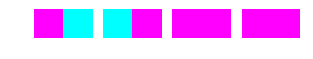

In [5]:
dataset_composite = np.append(dataset_one,image_composition(dataset_one, np.flipud(dataset_one)), axis = 0)
pp.images(dataset_composite, color_range=(0,1))

In [6]:
(num_items, num_vis ) = datasets.squash_images(dataset_composite).shape
num_hid = 2
rbm_a = RBM(num_hid, num_vis,num_items)
rbm_b = RBM(num_hid, num_vis,num_items)
sampler = ApproximatedMulDimSampler(rbm_a.weights ,rbm_b.weights, rbm_a.hidden_bias, rbm_b.hidden_bias)
trainer = ORBMTrainer(rbm_a,rbm_b, sampler)

INFO:rbmpy.trainer:Created Progress logger for task - rbmpy.trainer
INFO:rbmpy.trainer:0.0% complete
INFO:rbmpy.trainer:10.0% complete
INFO:rbmpy.trainer:20.0% complete
INFO:rbmpy.trainer:30.0% complete
INFO:rbmpy.trainer:40.0% complete
INFO:rbmpy.trainer:50.0% complete
INFO:rbmpy.trainer:60.0% complete
INFO:rbmpy.trainer:70.0% complete
INFO:rbmpy.trainer:80.0% complete
INFO:rbmpy.trainer:90.0% complete
INFO:rbmpy.trainer:100% complete


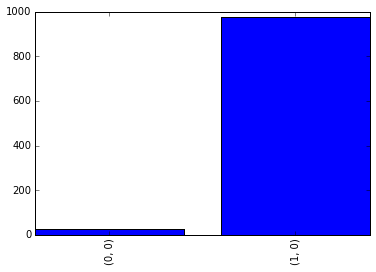

In [7]:
trainer.train(int(1e4),datasets.squash_images(dataset_composite), logging_freq=10)
pp.plot_dict(goodnight(rbm_a, VanillaSampler(rbm_a),1000,100)[0])

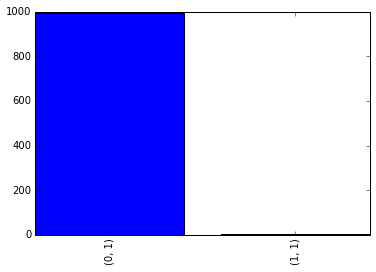

In [8]:
pp.plot_dict(goodnight(rbm_b, VanillaSampler(rbm_b),1000,100)[0])

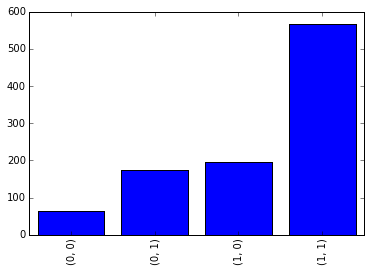

In [17]:
rbm_c = RBM(num_hid, num_vis,num_items)
c_trainer = VanillaTrainier(rbm_c, VanillaSampler(rbm_c))
c_trainer.train(int(1e4),datasets.squash_images(dataset_composite))
pp.plot_dict(goodnight(rbm_c, VanillaSampler(rbm_c),1000,100)[0])


```
dataset_two = np.copy(dataset_one)
np.random.shuffle(dataset_one)
np.random.shuffle(dataset_two)

dataset_composite = image_composition(dataset_one, dataset_two)
for i in range(10):
    np.random.shuffle(dataset_one)
    np.random.shuffle(dataset_two)

    dataset_composite = np.append(dataset_composite, image_composition(dataset_one , dataset_two), axis=0)

np.append(dataset_composite,dataset_one[:5],axis= 0)
pp.images(dataset_composite, color_range=(0,1))

print("Dataset of {1} by {2} with {0} items".format(*dataset_composite.shape))```

pp.images(rbm.weights_into_hiddens(rbm_a.weights), title="Hinton Diagram", cmap="gray")
pp.images(rbm.weights_into_hiddens(rbm_b.weights), title="Hinton Diagram", cmap="gray")

INFO:root:Ground Truth


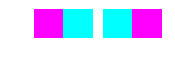

NameError: name 'dataset_two' is not defined

In [10]:
sampler_a = VanillaSampler(rbm_a)
sampler_b = VanillaSampler(rbm_b)

logging.info("Ground Truth")
pp.images(dataset_one)
pp.images(dataset_two)

logging.info("A")
pp.images(datasets.inflate_images(sampler_a.reconstruction_given_visible(datasets.squash_images(dataset_one))))
pp.images(datasets.inflate_images(sampler_a.reconstruction_given_visible(datasets.squash_images(dataset_two))))
logging.info("B")
pp.images(datasets.inflate_images(sampler_b.reconstruction_given_visible(datasets.squash_images(dataset_one))))
pp.images(datasets.inflate_images(sampler_b.reconstruction_given_visible(datasets.squash_images(dataset_two))))

pp.images(dataset_composite, color_range=(0,1))

## Reconstruction Probabilities ##

Below we see a few examples of reconstruction sigmoid values (i.e. before we would do a bernouli flip) given the ground truth dataset.

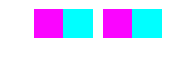

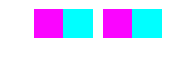

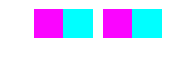

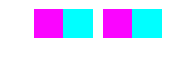

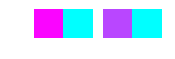

In [24]:
for i in range(5):
    pp.images(sampler_a.reconstruction_given_visible(datasets.squash_images(dataset_one), return_sigmoid=True).reshape(2,1,2), color_range=(0,1))

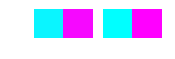

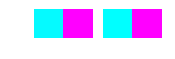

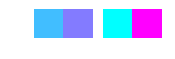

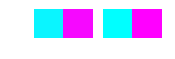

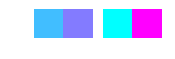

In [25]:
for i in range(5):
    pp.images(sampler_b.reconstruction_given_visible(datasets.squash_images(dataset_one), return_sigmoid=True).reshape(2,1,2) , color_range=(0,1))
